In [2]:
import pandas as pd
import numpy as np


In [3]:
#read in data
dat = pd.read_table('23andme_v5_hg19_ref.txt', names=['CHR','POS','dbSNP_ID','ALLELE_23andme'])
ann = pd.read_csv('var_drug_ann.tsv', sep = '\t')

In [4]:
#1. Map/merge the 23andme file and the variant-drug annotation file based on dbSNP_ID (also known as rsID).
ann = ann.rename(columns = {'Variant/Haplotypes':'dbSNP_ID',
                           'Gene':'GENE_SYMBOL',
                           'Drug(s)':'DRUG_NAME',
                           'Phenotype Category':'PHENOTYPE_CATEGORY',
                           'Significance':'SIGNIFICANCE',
                           'Notes':'NOTES',
                           'Sentence':'SENTENCE',
                           'Alleles':'ALLELE_PharmGKB'})

data = dat[['dbSNP_ID','ALLELE_23andme']].merge(ann[['dbSNP_ID','GENE_SYMBOL', 'DRUG_NAME',
       'PMID', 'PHENOTYPE_CATEGORY', 'SIGNIFICANCE', 'NOTES', 'SENTENCE',
       'ALLELE_PharmGKB']], how = 'inner', on = 'dbSNP_ID')

#data

In [5]:
#2. Filter the output so that it only contains significant associations (SIGNIFICANCE is yes) for variants that affect the drug efficacy (`PHENOTYPE_CATEGORY` is `efficacy`).
data = data[(data.SIGNIFICANCE == 'yes') & (data.PHENOTYPE_CATEGORY == 'Efficacy')]
data = data.reset_index(drop=True)
data

,dbSNP_ID,ALLELE_23andme,GENE_SYMBOL,DRUG_NAME,PMID,PHENOTYPE_CATEGORY,SIGNIFICANCE,NOTES,SENTENCE,ALLELE_PharmGKB
0,rs1801131,T,MTHFR,oxaliplatin,20385995,Efficacy,yes,Statistics given as trend for increased overal...,Genotypes GG + GT are associated with increase...,GG + GT
1,rs1801131,T,MTHFR,"Vitamin B-complex, Incl. Combinations",27035272,Efficacy,yes,Please note that allele has been complemented ...,Allele G is associated with increased response...,G
2,rs1801131,T,MTHFR,methotrexate,25618758,Efficacy,yes,Alleles given as C and A. Efficacy of treatmen...,Genotype GT is associated with decreased respo...,GT
3,rs1801131,T,MTHFR,methotrexate,23198157,Efficacy,yes,Patients with the GG genotype had better overa...,Genotype GG is associated with increased respo...,GG
4,rs1801131,T,MTHFR,methotrexate,24386571,Efficacy,yes,Patients with the TT genotype had significantl...,Genotype TT is associated with decreased respo...,TT
...,...,...,...,...,...,...,...,...,...,...
1298,rs502434,T,GRIA3,"Selective serotonin reuptake inhibitors, venla...",23394390,Efficacy,yes,Regression model looking at interaction betwee...,Genotype CC is associated with decreased respo...,CC
1299,rs3810651,T,GABRQ,venlafaxine,23394390,Efficacy,yes,Those with the AA/AT genotype are more likely ...,Genotypes AA + AT are associated with increase...,AA + AT
1300,rs17435,T,MECP2,"cisplatin, fluorouracil, mitoxantrone",21635146,Efficacy,yes,The study described this variant within the ME...,Allele A is associated with response to cispla...,A
1301,rs1734787,A,MECP2,"cisplatin, fluorouracil, mitoxantrone",21635146,Efficacy,yes,The study described this variant within the ME...,Allele A is associated with response to cispla...,A


In [6]:
#3. Save the output of the filtering step in a tab-separated file (23andme_PharmGKB_map.tsv) with the following columns:
#dbSNP_ID, GENE_SYMBOL, DRUG_NAME, NOTES, SENTENCE, ALLELE_PharmGKB, ALLELE_23andme

data.to_csv('23andme_PharmGKB_map.tsv',sep='\t', columns = ['dbSNP_ID', 'GENE_SYMBOL', 'DRUG_NAME', 'NOTES', 'SENTENCE', 'ALLELE_PharmGKB', 'ALLELE_23andme'])

In [7]:
#4. Create a tab separated file (23andme_PharmGKB_summary.tsv) with summarized data with the following columns:
#GENE_SYMBOL, DRUG_NAME, dbSNP_IDs (list of IDs separated by ";")

#There are rows with multiple drug names and multiple gene symbols so we split those and get list of unique ids with respective gene&drug
data1= pd.DataFrame({'dbSNP_ID': data.dbSNP_ID,
                     'GENE_SYMBOL':data.GENE_SYMBOL,
                     'idx': data.index})

data_drug_split = pd.DataFrame({'DRUG_NAME': [],
                                'idx': []})
data_drug_split.DRUG_NAME = data.DRUG_NAME.str.split(', ').explode()
data_drug_split.idx = data_drug_split.index
data_drug_split = data_drug_split.merge(data1, how='left', on='idx')
data_drug_split.idx = data_drug_split.index

data_gene_split = pd.DataFrame({'GENE_SYMBOL': [],
                                'idx': []})
data_gene_split.GENE_SYMBOL = data_drug_split.GENE_SYMBOL.str.split(', ').explode()
data_gene_split.idx = data_gene_split.index

data_drug_split = data_drug_split.drop(columns = ['GENE_SYMBOL'])
data_gene_split = data_gene_split.merge(data_drug_split, how='left', on='idx')
data_gene_split = data_gene_split.drop(columns = ['idx'])

data_gene_split

,GENE_SYMBOL,DRUG_NAME,dbSNP_ID
0,MTHFR,oxaliplatin,rs1801131
1,MTHFR,Vitamin B-complex,rs1801131
2,MTHFR,Incl. Combinations,rs1801131
3,MTHFR,methotrexate,rs1801131
4,MTHFR,methotrexate,rs1801131
...,...,...,...
2107,MECP2,fluorouracil,rs1734787
2108,MECP2,mitoxantrone,rs1734787
2109,MECP2,cisplatin,rs1734791
2110,MECP2,fluorouracil,rs1734791


In [8]:
data_gene_split.groupby(['GENE_SYMBOL','DRUG_NAME']).value_counts()

GENE_SYMBOL  DRUG_NAME               dbSNP_ID  
ABCA1        atorvastatin            rs2230806     1
             fenofibrate             rs2230806     2
                                     rs2230808     1
             rosuvastatin            rs2230806     1
             simvastatin             rs2230806     1
                                                  ..
ZNF432       fluticasone propionate  rs3752120     1
             fluticasone/salmeterol  rs3752120     1
ZNF697       interferon beta-1a      rs10494227    1
             interferon beta-1b      rs10494227    1
ZNF804A      antipsychotics          rs1344706     1
Length: 1400, dtype: int64

In [9]:
data_summ = data_gene_split.groupby(['GENE_SYMBOL','DRUG_NAME'])['dbSNP_ID'].agg(lambda x: ';'.join(x)).reset_index()
data_summ = data_summ.rename(columns = {'dbSNP_ID':'dbSNP_IDs'})
data_summ
#strip

,GENE_SYMBOL,DRUG_NAME,dbSNP_IDs
0,ABCA1,atorvastatin,rs2230806
1,ABCA1,fenofibrate,rs2230808;rs2230806;rs2230806
2,ABCA1,rosuvastatin,rs2230806
3,ABCA1,simvastatin,rs2230806
4,ABCB1,antipsychotics,rs1128503
...,...,...,...
1063,ZNF432,fluticasone propionate,rs3752120
1064,ZNF432,fluticasone/salmeterol,rs3752120
1065,ZNF697,interferon beta-1a,rs10494227
1066,ZNF697,interferon beta-1b,rs10494227


In [10]:
d = data_summ['dbSNP_IDs'].str.contains(';')
sum(d)

314

In [11]:
data_summ.to_csv('23andme_PharmGKB_summary.tsv',sep='\t')

### Part 5

In [66]:
import matplotlib.pyplot as plt
# load summarized data
summarized_data = pd.read_csv('23andme_PharmGKB_summary.tsv',sep='\t')

# Count the occurrences of each GENE_SYMBOL
drug_counts = data['GENE_SYMBOL'].value_counts()
drug_counts.describe()

# find range of values 
drug_bin_max = drug_counts.max()
drug_bin_min = drug_counts.min()
# set bin width to be single integer
bin_width = 1


63


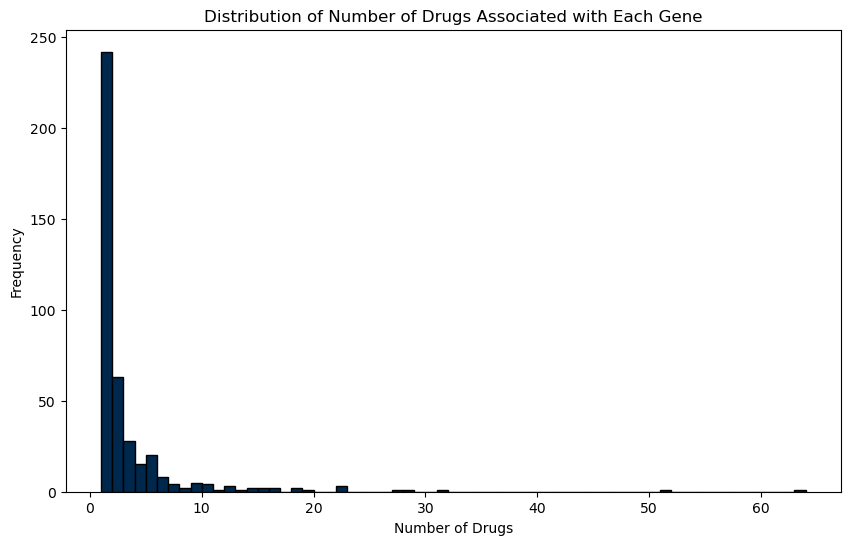

In [76]:

# Plotting the histogram for Distribution of # of drugs with each gene
plt.figure(figsize=(10, 6))
plt.hist(drug_counts, bins = range(drug_bin_min, drug_bin_max+2, bin_width),color='#00274C', edgecolor='black')
plt.title('Distribution of Number of Drugs Associated with Each Gene')
plt.xlabel('Number of Drugs')
plt.ylabel('Frequency')
plt.show()

In [73]:
# Counting the number of SNPs for each gene
# Splitting and exploding the dbSNP_IDs column
data['dbSNP_ID'] = data['dbSNP_ID'].apply(lambda x: str(x).split(';'))

# Convenient way of breaking apart column indexes with multiple values contained into new rows
data_exploded = data.explode('dbSNP_ID')

# Count unique SNPs for each gene
unique_snp_counts = data_exploded.groupby('GENE_SYMBOL')['dbSNP_ID'].nunique()

bin_max = unique_snp_counts.max()
bin_min = unique_snp_counts.min()
bin_width = 1
print(bin_max)


9


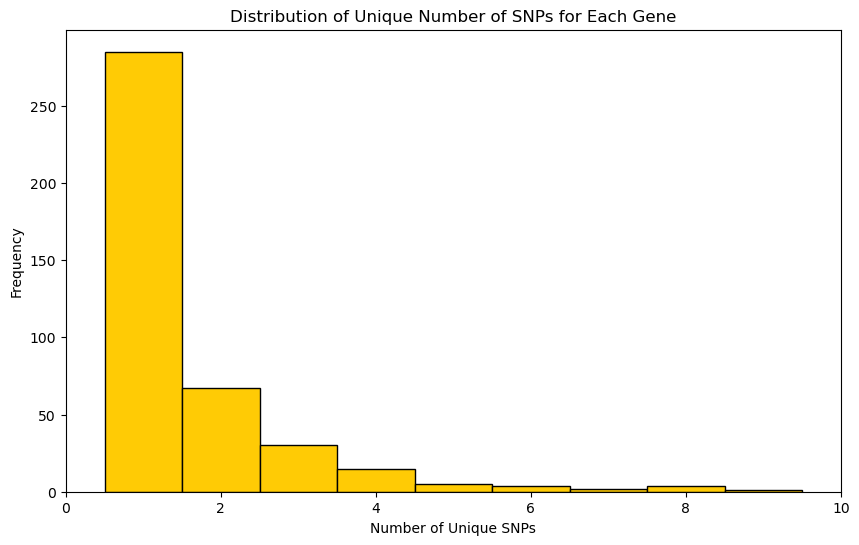

In [75]:

# Plotting the histogram for SNP counts
plt.figure(figsize=(10, 6))
plt.hist(unique_snp_counts,bins = range(bin_min, bin_max+2, bin_width),color='#FFCB05', edgecolor='black', align = 'left')
plt.xlim(0,bin_max+1)
plt.title('Distribution of Unique Number of SNPs for Each Gene')
plt.xlabel('Number of Unique SNPs')
plt.ylabel('Frequency')
plt.show()
